<a href="https://colab.research.google.com/github/dcpatton/Structured-Data/blob/main/deep_solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://web.stanford.edu/group/deepsolar/home.html

TODO: 

1. Improve current model arch
2. Predict a DeepSolar value and remove others.
3. Predict multiple DeepSolar outputs



In [1]:
import tensorflow as tf
import random
import pandas as pd
pd.set_option('display.max_info_columns', 200)
# pd.set_option('display.max_columns', 100)

seed=53
tf.random.set_seed(seed)
random.seed(seed)

tf.__version__

'2.8.0'

In [2]:
# pd.reset_option('all')

# Get the data

In [3]:
!curl http://web.stanford.edu/group/deepsolar/deepsolar_tract.csv -o deepsolar_tract.csv
!curl http://web.stanford.edu/group/deepsolar/deepsolar_tract_meta.csv -o deepsolar_tract_meta.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  107M  100  107M    0     0  1785k      0  0:01:01  0:01:01 --:--:-- 1805k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15301  100 15301    0     0  55843      0 --:--:-- --:--:-- --:--:-- 55843


In [4]:
data_df = pd.read_csv('deepsolar_tract.csv', encoding='latin-1', index_col=0)
data_df.shape

(72537, 168)

In [5]:
data_df.head()

,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,education_high_school_graduate,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0.0,0.0,0.000000,27145011200,70352.789869,Stearns County,569,1690,13,1757,...,39,11,13,34,0,0,25,12,0,9.46
1,25.0,21.0,1133.436461,27145011301,61727.085202,Stearns County,674,1434,108,767,...,39,11,13,34,0,0,25,12,0,9.46
2,3.0,3.0,64.505776,27145011302,71496.886583,Stearns County,854,1459,31,1541,...,39,11,13,34,0,0,25,12,0,9.46
3,0.0,0.0,0.000000,27145011304,86840.152755,Stearns County,640,1116,68,1095,...,39,11,13,34,0,0,25,12,0,9.46
4,5.0,5.0,164.583303,27145011400,89135.315597,Stearns County,654,1314,15,982,...,39,11,13,34,0,0,25,12,0,9.46


In [6]:
assert data_df.fips.nunique() == data_df.shape[0]

In [7]:
# predict total_panel_area, so remove tile_count, solar_system_count, heating fuel data, solar panel , tile_count_, solar_system_, total_panel_area_, number_of_solar
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72537 entries, 0 to 72537
Data columns (total 168 columns):
 #    Column                                   Non-Null Count  Dtype  
---   ------                                   --------------  -----  
 0    tile_count                               72537 non-null  float64
 1    solar_system_count                       72537 non-null  float64
 2    total_panel_area                         72537 non-null  float64
 3    fips                                     72537 non-null  int64  
 4    average_household_income                 71651 non-null  float64
 5    county                                   72537 non-null  object 
 6    education_bachelor                       72537 non-null  int64  
 7    education_college                        72537 non-null  int64  
 8    education_doctoral                       72537 non-null  int64  
 9    education_high_school_graduate           72537 non-null  int64  
 10   education_less_than_high_school 

# Clean data

In [8]:
# has values of inf
data_df.drop(['solar_panel_area_per_capita'], axis='columns', inplace=True)

In [9]:
counts = data_df.isna().sum()
counts[counts > 0]

average_household_income                  886
gini_index                                847
land_area                                  24
per_capita_income                         643
population_density                        316
                                        ...  
voting_2012_dem_percentage              10554
voting_2012_gop_percentage              10554
number_of_years_of_education              607
diversity                                 597
number_of_solar_system_per_household      546
Length: 102, dtype: int64

In [10]:
data_df.drop(['number_of_solar_system_per_household', 'voting_2012_dem_percentage', 
              'voting_2012_gop_percentage'], axis='columns', inplace=True)

In [11]:
def impute_with_county_mean(column_name):
  missing_df = data_df.loc[data_df[column_name].isna()]

  for _,row in missing_df.iterrows():
    temp_df = data_df.loc[(data_df['county'] == row.county) & (data_df['state'] == row.state) & 
                          (data_df[column_name].notna())]
    value = temp_df.average_household_income.mean()
    data_df.loc[data_df['fips'] == row.fips, [column_name]] = value

In [12]:
%%time
counts = data_df.isna().sum()
counts = counts[counts > 0]
counts = list(counts.index)
for column_name in counts:
  print(column_name)
  impute_with_county_mean(column_name)


average_household_income
gini_index
land_area
per_capita_income
population_density
total_area
water_area
education_less_than_high_school_rate
education_high_school_graduate_rate
education_college_rate
education_bachelor_rate
education_master_rate
education_professional_school_rate
education_doctoral_rate
race_white_rate
race_black_africa_rate
race_indian_alaska_rate
race_asian_rate
race_islander_rate
race_other_rate
race_two_more_rate
employ_rate
poverty_family_below_poverty_level_rate
heating_fuel_gas_rate
heating_fuel_electricity_rate
heating_fuel_fuel_oil_kerosene_rate
heating_fuel_coal_coke_rate
heating_fuel_solar_rate
heating_fuel_other_rate
heating_fuel_none_rate
solar_panel_area_divided_by_area
median_household_income
average_household_size
housing_unit_median_value
housing_unit_median_gross_rent
lat
lon
elevation
heating_design_temperature
cooling_design_temperature
earth_temperature_amplitude
frost_days
air_temperature
relative_humidity
daily_solar_radiation
atmospheric_pressu

In [13]:
counts = data_df.isna().sum()
counts = counts[counts > 0]
counts

land_area                            3
population_density                   3
total_area                           3
water_area                           3
solar_panel_area_divided_by_area     3
median_household_income              1
housing_unit_median_value            2
housing_unit_median_gross_rent       1
lat                                 11
lon                                 11
elevation                           11
heating_design_temperature          11
cooling_design_temperature          11
earth_temperature_amplitude         11
frost_days                          11
air_temperature                     11
relative_humidity                   11
daily_solar_radiation               11
atmospheric_pressure                11
wind_speed                          11
earth_temperature                   11
heating_degree_days                 11
cooling_degree_days                 11
dropout_16_19_inschool_rate          1
voting_2016_dem_percentage           3
voting_2016_gop_percentag

In [14]:
# drop remaining rows with missing values
print(data_df.shape)
data_df = data_df.loc[data_df['land_area'].notna()]
data_df = data_df.loc[data_df['lat'].notna()]
data_df = data_df.loc[data_df['housing_unit_median_value'].notna()]
data_df = data_df.loc[data_df['median_household_income'].notna()]
data_df = data_df.loc[data_df['housing_unit_median_gross_rent'].notna()]
print(data_df.shape)

(72537, 164)
(72519, 164)


In [15]:
counts = data_df.isna().sum()
counts = counts[counts > 0] 
counts

Series([], dtype: int64)

In [16]:
# county, state, 
# combine them and then ?

In [17]:
import numpy as np
# data_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
# data_df['electricity_price_transportation'] = data_df['electricity_price_transportation'].astype(np.float64)

In [18]:
# counts = data_df.isna().sum()
# counts = counts[counts > 0] 
# counts

In [19]:
# impute_with_county_mean('electricity_price_transportation')

In [20]:
# counts = data_df.isna().sum()
# counts = counts[counts > 0] 
# counts

In [21]:
data_df.drop(['electricity_price_transportation'], axis='columns', inplace=True)

In [22]:
data_df['voting_2016_dem_win'] = data_df['voting_2016_dem_win'].astype(int)
data_df['voting_2012_dem_win'] = data_df['voting_2012_dem_win'].astype(int)

# Prepare Data

In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_df, test_size=0.2)
print(len(train), 'train examples')
print(len(test), 'test examples')

58015 train examples
14504 test examples


In [24]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('total_panel_area')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=1024)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [25]:
numeric_columns = list(data_df.columns)
numeric_columns.remove('total_panel_area') # target
numeric_columns.remove('county') # used as cross column with state later?
numeric_columns.remove('state') # used as cross column with county later?
numeric_columns.remove('voting_2016_dem_win') # indicator
numeric_columns.remove('voting_2012_dem_win') # indicator

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for column in numeric_columns:  
  print(column)
  train[[column]] = scaler.fit_transform(train[[column]])
  test[[column]] = scaler.transform(test[[column]])

tile_count
solar_system_count
fips
average_household_income
education_bachelor
education_college
education_doctoral
education_high_school_graduate
education_less_than_high_school
education_master
education_population
education_professional_school
employed
gini_index
heating_fuel_coal_coke
heating_fuel_electricity
heating_fuel_fuel_oil_kerosene
heating_fuel_gas
heating_fuel_housing_unit_count
heating_fuel_none
heating_fuel_other
heating_fuel_solar
land_area
per_capita_income
population
population_density
poverty_family_below_poverty_level
poverty_family_count
race_asian
race_black_africa
race_indian_alaska
race_islander
race_other
race_two_more
race_white
total_area
unemployed
water_area
education_less_than_high_school_rate
education_high_school_graduate_rate
education_college_rate
education_bachelor_rate
education_master_rate
education_professional_school_rate
education_doctoral_rate
race_white_rate
race_black_africa_rate
race_indian_alaska_rate
race_asian_rate
race_islander_rate
race_

In [27]:
from tensorflow import feature_column

feature_columns = []

for column in numeric_columns:
  feature_columns.append(feature_column.numeric_column(column))

indicator_column_names = ['voting_2016_dem_win', 'voting_2012_dem_win']
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, data_df[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

state = feature_column.categorical_column_with_vocabulary_list(
      'state', data_df.state.unique())
state_embedding = feature_column.embedding_column(state, dimension=8)
feature_columns.append(state_embedding)

county = feature_column.categorical_column_with_hash_bucket(
      'county', hash_bucket_size=128)
hashed_column = feature_column.indicator_column(county)
feature_columns.append(hashed_column)

In [28]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [29]:
batch_size = 8
train_ds = df_to_dataset(train, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# Model

In [30]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, Dropout

model = tf.keras.Sequential([
  feature_layer,
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [31]:
filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, 
                                        save_weights_only=True, mode='auto')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

history = model.fit(train_ds, epochs=200, validation_data=test_ds, callbacks=[mc, es],
                    verbose=1)

Epoch 1/200
7252/7252 [==============================] - 144s 19ms/step - loss: 4535400.0000 - mae: 500.7239 - val_loss: 2367528.5000 - val_mae: 347.7760
Epoch 2/200
7252/7252 [==============================] - 144s 20ms/step - loss: 2712286.0000 - mae: 379.4484 - val_loss: 1798111.5000 - val_mae: 324.6808
Epoch 3/200
7252/7252 [==============================] - 137s 19ms/step - loss: 1911710.7500 - mae: 331.8267 - val_loss: 1163106.5000 - val_mae: 276.6219
Epoch 4/200
7252/7252 [==============================] - 142s 20ms/step - loss: 2748916.2500 - mae: 291.2501 - val_loss: 1147287.8750 - val_mae: 252.5910
Epoch 5/200
7252/7252 [==============================] - 144s 20ms/step - loss: 2041180.3750 - mae: 247.1236 - val_loss: 1315393.3750 - val_mae: 255.3778
Epoch 6/200
7252/7252 [==============================] - 146s 20ms/step - loss: 1232775.6250 - mae: 235.8497 - val_loss: 827819.0625 - val_mae: 214.9782
Epoch 7/200
7252/7252 [==============================] - 144s 20ms/step - los

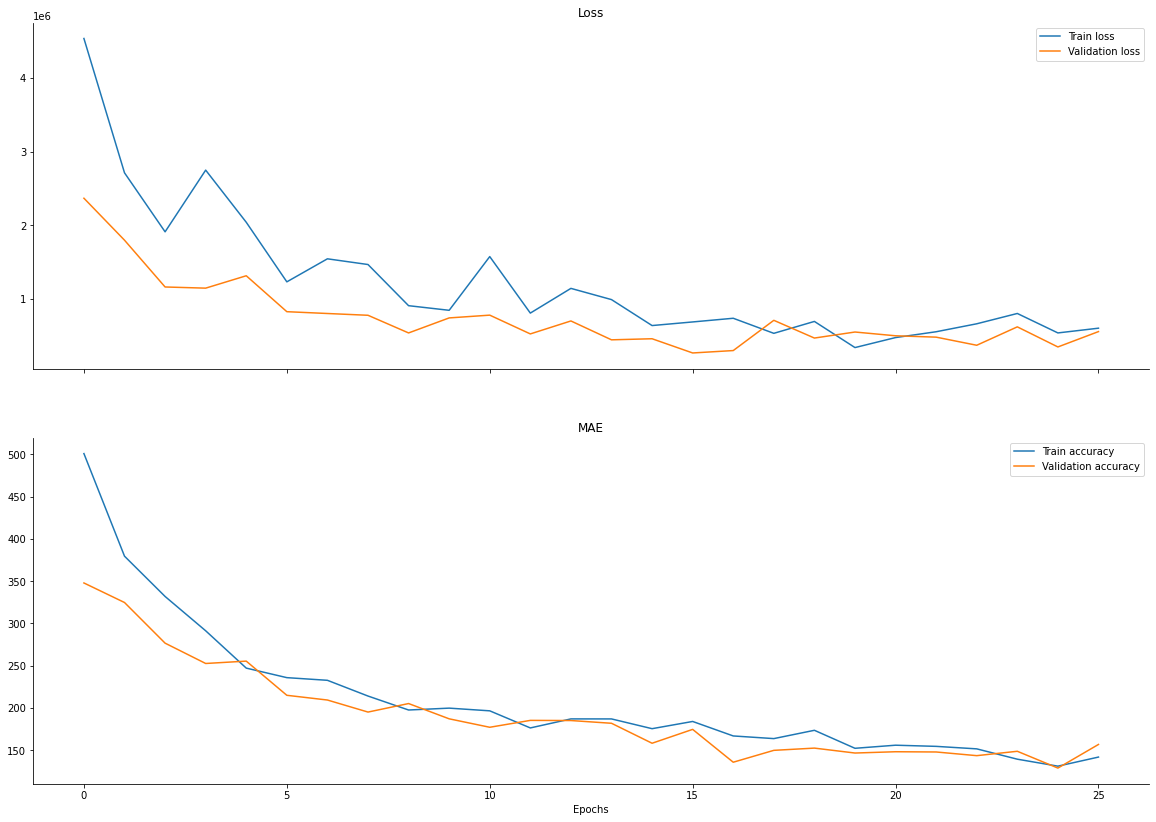

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Train accuracy')
ax2.plot(history['val_mae'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [33]:
model.load_weights('model.h5')
model.evaluate(test_ds)

1813/1813 [==============================] - 24s 13ms/step - loss: 267672.1562 - mae: 174.6855


[267672.15625, 174.685546875]

# Results

* MinMaxScalar:   loss: 349852.2500 - mae: 217.9379
* No scaling:     loss: 39541308.0000 - mae: 1853.0940
* RobustScaler:   loss: 2973207.7500 - mae: 192.8916
* StandardScaler: **loss: 42956.1250 - mae: 76.7915**
* deeper NN:      loss: 147935.1406 - mae: 126.3681
* thicker NN:     loss: 39153.5625 - mae: 78.8219
* new arch:       loss: 582790.4375 - mae: 286.8643

